# [Genre] Data Collection

In [1]:
import utility
import os
import math
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tensorflow.keras.utils import to_categorical

In [14]:
DATA_PATH = '../data/'
AUDIO_ROOT_PATH = DATA_PATH + 'genre-audios/'
MELSPECS_FOLDER = DATA_PATH + 'genre-melspecs-10000/'
SPECS_FOLDER = DATA_PATH + 'genre-specs-10000/'
MFCCS_FOLDER = DATA_PATH + 'genre-mfccs-10000/'
SPLITS_FOLDER = DATA_PATH + 'genre-splits/split-1/'

SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION # Here: 661 500

# <a name="example"> </a>  1. A Single Audio File Example

## 1.1. Extracting an Audio Signal
A __sound__ is produced by the vibration of an object and is transmitted through the air as pressure oscillations. The change in air pressure over time can be represented by the __waveform__ of the sound. More precisely, it shows the deviation of the air pressure from the average air pressure. 

The primary package that will be used to process audio files is [LibROSA](https://librosa.org/librosa/0.4.1/index.html), a Python library that allows us to extract waveforms from audio files along with several other features.

In [3]:
# Extracting the wave `y` (an array of amplitudes or samples) 
# and sampling rate `sr` (number of samples per second) of the audio file
y, sr = librosa.load(AUDIO_ROOT_PATH + 'rock/rock.00000.wav')

In [4]:
# Checking the shape of the wave
y.shape

(661794,)

In [5]:
# Checking the sampling rate
sr

22050

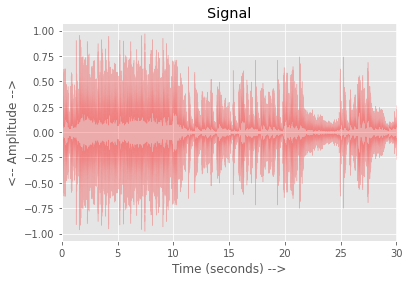

In [20]:
# Plotting the waveform
plt.figure()
librosa.display.waveplot(y=y, sr=sr, alpha=0.25, color='red')
plt.title('Signal')
plt.xlabel('Time (seconds) -->')
plt.ylabel('<-- Amplitude -->')
plt.show()

This visualization is called the __time-domain__ representation of a given signal. This shows us the loudness (amplitude) of sound wave changing with time. 
<br/>Note: amplitude is actually the amplitude of air particles which are oscillating because of the pressure change in the atmosphere due to sound.


But these amplitudes are not very informative, as they only talk about the loudness of audio recording. To better understand the audio signal, it is necessary to transform it into the __frequency-domain__. The __frequency-domain__ representation of a signal tells us what different frequencies are present in the signal.

## 1.2. Fast Fourier Transform (FFT)
An audio signal is composed of several single-frequency sound waves. The resultant amplitudes of those multiple waves are shown in the above pressure-time plot. The __[Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform)__ is a mathematical formula that allows us to decompose a signal into it's individual frequencies and the frequency's amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a __spectrum__. The __[Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)__ is an efficient way to compute the Fourier transform.

In [7]:
# Computing the FFT on a single short time window of length 2048 (standard for music audio)
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length=n_fft+1))

Text(0, 0.5, 'Amplitude')

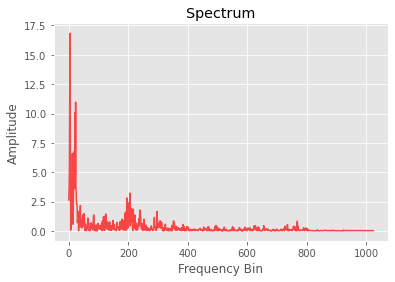

In [21]:
# Plotting the signal after appying the FFT
plt.plot(ft, alpha=0.7, color='red')
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

## 1.3. Spectrograms
The spectrum of a signal does not capture time information: it only tells us which frequencies are played but not when. __Spectrograms__ are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the fast Fourier transform on short time windows __[(Short-time Fourier transform)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)__ of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals. 

Text(0.5, 1.0, 'Spectrogram')

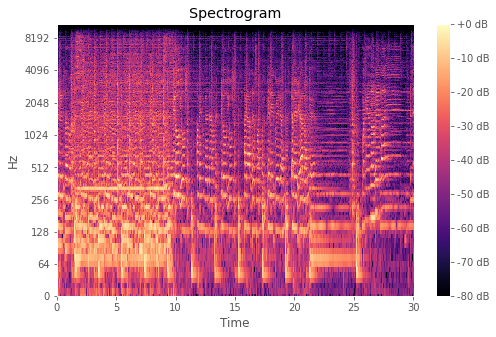

In [22]:
# Computing the spectrogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(np.abs(spec), ref=np.max) # Converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

## 1.4. Mel Spectrograms
Now, what about the "mel" part? Humans are better at detecting differences in lower frequencies than higher frequencies. The __[mel scale](https://en.wikipedia.org/wiki/Mel_scale)__ transforms the frequency scale such that sounds at equal distances from each other also sound equal in distance. For example, let's take the deviation between pure tones of frequencies 300 Hz and 600 Hz as a reference. In order to reproduce the same deviation from a pure tone of frequency 1 000 Hz, a second pure tone will have to be presented, not of frequency 2 000 Hz, but of about 2 563 Hz.
- 300 Hz corresponds to 402 mels and 600 Hz corresponds to 698 mels. The ratio between the two is therefore 1.735.
- 1 000 Hz corresponds to 1 000 mels by definition. The difference perceived as identical must be with a sound at 1,735 mels, which corresponds to 2,563 Hz.

A __mel spectrogram__ is a spectrogram where the frequencies are converted to the mel scale.

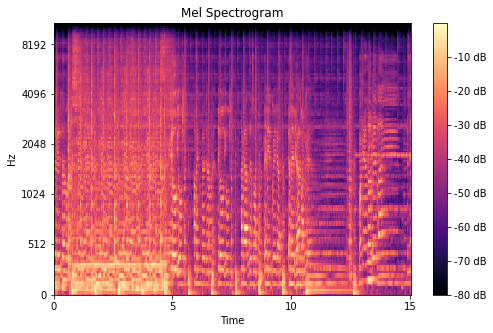

In [10]:
# Computing the mel spectrogram
melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
melspec = librosa.power_to_db(melspec, ref=np.max) # Converting to decibals

# Plotting the mel spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(melspec, y_axis='mel', x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

## 1.5. Mel Frequency Cepstral Coefficients (MFCCs)
The [mel frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. In MIR, it is often used to describe timbre.

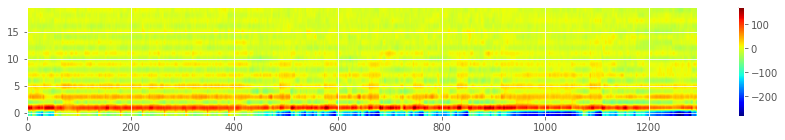

In [23]:
mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)
plt.figure(figsize=(15,2))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='jet')
plt.colorbar()

# <a name="extract"> </a>  2. Compute Spectrograms, Mel Spectrograms and MFCCs from Audio Files

## 2.1. Checking the Size of Spectrograms and Mel Spectrograms
All spectrograms and mel spectrograms have to be the same size in order to feed them into a neural network.

In [12]:
def check_size(dataset_path, compute_spec=False, compute_melspec=False, 
               n_fft=1024, hop_length=512, segment_duration=3, segment_overlap=0.5, num_segments=None, 
               n_mels=128):
    
    # Creating an empty list for the size of each spectrogram/mel spectrogram
    if compute_spec:
        sizes_spec = []
    if compute_melspec:
        sizes_melspec = []

    # Computing the number of samples per segment for spectrogram/mel spectrogram extraction
    if num_segments:
        num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    else:
        num_samples_per_segment = int(SAMPLE_RATE * segment_duration)
        num_segments = int((DURATION / (segment_duration * segment_overlap)) - 1)
        
    # Looping through all the genres
    for dirpath, _, filenames in os.walk(dataset_path):

        # Ensuring that we're not at the root level
        if dirpath is not dataset_path:

            # Processing files for a specific genre
            for fn in filenames:
                
                # Loading the audio file
                file_path = os.path.join(dirpath, fn)
                y, _ = librosa.load(file_path, sr=SAMPLE_RATE)

                # Processing segments, extracting spectrogram/mel spectrograms and storing data
                for s in range(num_segments):
                    start_sample = int(num_samples_per_segment * segment_overlap * s) 
                    finish_sample = start_sample + num_samples_per_segment
                    
                    ##### SPECS #####
                    if compute_spec:
                        spec = librosa.core.stft(y[start_sample:finish_sample],
                                                        n_fft=n_fft,
                                                        hop_length=hop_length)

                        spec = librosa.amplitude_to_db(np.abs(spec), ref=np.max) # Converting to decibals
                        
                        # Adding the shape to the list of size
                        sizes_spec.append(spec.shape)
                    
                    ##### MEL SPECS #####
                    if compute_melspec:
                        
                        # Computing the mel spectrograms
                        melspec = librosa.feature.melspectrogram(y=y[start_sample:finish_sample], 
                                                                 sr=sr, 
                                                                 n_fft=n_fft, 
                                                                 hop_length=hop_length,
                                                                 n_mels=n_mels)

                        melspec = librosa.power_to_db(melspec, ref=np.max)
                        
                        # Adding the shape to the list of size
                        sizes_melspec.append(melspec.shape)
                        

    # Checking if all spectrograms/mel spectrograms are the same size
    if compute_spec:
        same_size_spec = (len(set(sizes_spec)) == 1)
        max_size_spec = max(sizes_spec)
        print(f'Do all the spectrograms have the same size? {same_size_spec}')
        print(f'The maximum size of spectrograms: {max_size_spec}')
        
    if compute_melspec:
        same_size_melspec = (len(set(sizes_melspec)) == 1)
        max_size_melspec = max(sizes_melspec)
        print(f'Do all the mel spectrograms have the same size? {same_size_melspec}')
        print(f'The maximum size of mel spectrograms: {max_size_melspec}')

In [13]:
# Checking size of spectrograms
check_size(dataset_path=AUDIO_ROOT_PATH, compute_spec=True, num_segments=10)

Do all the spectrograms have the same size? True
The maximum size of spectrograms: (513, 130)


In [14]:
# Checking size of mel spectrograms
check_size(dataset_path=AUDIO_ROOT_PATH, compute_melspec=True)

Do all the mel spectrograms have the same size? False
The maximum size of mel spectrograms: (128, 130)


In [5]:
MAX_SIZE_MELSPEC = (128, 130)

The sizes are not the same, so we will have to pad the smaller arrays with zeros to make them all the same size.

## 2.2. Creating Datasets

In [3]:
def create_dataset(dataset_path, melspecs_folder=None, specs_folder=None, mfccs_folder=None,
                   n_fft=1024, hop_length=512, segment_duration=3, segment_overlap=0.5, 
                   num_segments=None, n_mels=128, n_mfcc=20):

    
    # Computing the number of samples per segment 
    if num_segments:
        num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    else:
        num_samples_per_segment = int(SAMPLE_RATE * segment_duration)
        num_segments = int((DURATION / (segment_duration * segment_overlap)) - 1)

    # Computing the expected number of mfcc vectors per segment, or number of frames per segment
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length) 

    # Looping through all the genres
    for dirpath, _, filenames in os.walk(dataset_path):

        # Ensuring that we're not at the root level
        if dirpath is not dataset_path:

            # Saving the semantic label
            dirpath_components = dirpath.split("/") # data/genres/blues => ["data", "genres", "blues"]
            semantic_label = dirpath_components[-1]
            print("Processing {}".format(semantic_label))
            
            
            # Processing files for a specific genre
            for fn in filenames:
                
                # Loading the audio file
                file_path = os.path.join(dirpath, fn)
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                # Processing segments, extracting mel spectrograms and storing data
                for s in range(num_segments):
                    start_sample = int(num_samples_per_segment * segment_overlap * s)
                    finish_sample = start_sample + num_samples_per_segment
                    
                    ##### Start: MEL SPECTROGRAMS #####
                    if melspecs_folder:
                        melspec = librosa.feature.melspectrogram(y=y[start_sample:finish_sample], 
                                                                sr=sr, 
                                                                n_fft=n_fft, 
                                                                hop_length=hop_length,
                                                                n_mels=n_mels)
                        
                        melspec = librosa.power_to_db(melspec, ref=np.max)
                        
                        # Adjusting the size to be `MAX_SIZE_MELSPEC`
                        if melspec.shape != MAX_SIZE_MELSPEC:
                            melspec.resize(MAX_SIZE_MELSPEC)

                        # Saving the mel spectrogram into a .npy file
                        npy_filename = melspecs_folder + fn.replace('.wav', f'.{s}.melspec.npy')
                        np.save(npy_filename, melspec)
                    ##### End: MEL SPECTROGRAMS #####

                    ##### Start: SPECTROGRAMS #####
                    if specs_folder:
                        spec = librosa.core.stft(y[start_sample:finish_sample],
                                                n_fft=n_fft,
                                                hop_length=hop_length)
                        
                        spec = librosa.amplitude_to_db(np.abs(spec), ref=np.max) 

                        # Saving the spectrogram into a .npy file
                        npy_filename = specs_folder + fn.replace('.wav', f'.{s}.spec.npy')
                        np.save(npy_filename, spec)
                    ##### End: SPECTROGRAMS #####

                    ##### Start: MFCCs #####
                    if mfccs_folder:
                        mfcc = librosa.feature.mfcc(y[start_sample:finish_sample],
                                                    sr=sr,
                                                    n_fft=n_fft,
                                                    n_mfcc=n_mfcc,
                                                    hop_length=hop_length)
                        
                        
                        # Storing the segment's mfccs if it has the expected length 
                        # All data have to be the same shape in order to feed them into our neural network
                        if mfcc.shape[1] == expected_num_mfcc_vectors_per_segment:
                            npy_filename = mfccs_folder + fn.replace('.wav', f'.{s}.mfcc.npy')
                            np.save(npy_filename, mfcc)
                    ##### End: MFCCs #####
            
    print('Creating dataset done!')

In [17]:
# Extracting mel spectrograms and mfccs for every 3-seconds excerpt of each track with a 50% overlap
create_dataset(dataset_path=AUDIO_ROOT_PATH, melspecs_folder=MELSPECS_FOLDER, mfccs_folder=MFCCS_FOLDER)

Processing metal
Processing disco
Processing blues
Processing country
Processing pop
Processing reggae
Processing hiphop
Processing classical
Processing jazz
Processing rock
Creating dataset done!


In [6]:
# Extracting mel spectrograms and mfccs for every 3-seconds excerpt of each track with no overlap
create_dataset(dataset_path=AUDIO_ROOT_PATH, melspecs_folder=MELSPECS_FOLDER, mfccs_folder=MFCCS_FOLDER, num_segments=10)

Processing metal
Processing disco
Processing blues
Processing country
Processing pop
Processing reggae
Processing hiphop
Processing classical
Processing jazz
Processing rock
Creating dataset done!


# 3. Splitting data into train, validation, and test sets

In [8]:
# Loading the label map
with open(DATA_PATH + 'genre_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [9]:
# Loading the filenames and corresponding labels for each type of input 
X_filenames_melspec, y_melspec = utility.load_data(MELSPECS_FOLDER, label_map)
X_filenames_spec, y_spec = utility.load_data(SPECS_FOLDER, label_map)
X_filenames_mfcc, y_mfcc = utility.load_data(MFCCS_FOLDER, label_map)

Loading data done!
Loading data done!
Loading data done!


In [10]:
# One hot encoding the labels
one_hot_y_melspec = to_categorical(y_melspec, num_classes=10)
one_hot_y_spec = to_categorical(y_spec, num_classes=10)
one_hot_y_mfcc = to_categorical(y_mfcc, num_classes=10)

In [15]:
# Splitting the filenames into train, validation, and test sets with respect to the relative distribution of instances per category in our dataset
X_train_filenames_melspec, X_val_filenames_melspec, X_test_filenames_melspec, one_hot_y_train_melspec, one_hot_y_val_melspec, one_hot_y_test_melspec = utility.data_split(X_filenames_melspec, one_hot_y_melspec, train_size=0.8)

X_train_filenames_spec, X_val_filenames_spec, X_test_filenames_spec, one_hot_y_train_spec, one_hot_y_val_spec, one_hot_y_test_spec = utility.data_split(X_filenames_spec, one_hot_y_spec, train_size=0.8)

X_train_filenames_mfcc, X_val_filenames_mfcc, X_test_filenames_mfcc, one_hot_y_train_mfcc, one_hot_y_val_mfcc, one_hot_y_test_mfcc = utility.data_split(X_filenames_mfcc, one_hot_y_mfcc, train_size=0.8)

In [16]:
np.save(SPLITS_FOLDER + 'X_train_filenames_melspec.npy', X_train_filenames_melspec)
np.save(SPLITS_FOLDER + 'X_val_filenames_melspec.npy', X_val_filenames_melspec)
np.save(SPLITS_FOLDER + 'X_test_filenames_melspec.npy', X_test_filenames_melspec)

np.save(SPLITS_FOLDER + 'X_train_filenames_spec.npy', X_train_filenames_spec)
np.save(SPLITS_FOLDER + 'X_val_filenames_spec.npy', X_val_filenames_spec)
np.save(SPLITS_FOLDER + 'X_test_filenames_spec.npy', X_test_filenames_spec)

np.save(SPLITS_FOLDER + 'X_train_filenames_mfcc.npy', X_train_filenames_mfcc)
np.save(SPLITS_FOLDER + 'X_val_filenames_mfcc.npy', X_val_filenames_mfcc)
np.save(SPLITS_FOLDER + 'X_test_filenames_mfcc.npy', X_test_filenames_mfcc)

In [17]:
np.save(SPLITS_FOLDER + 'one_hot_y_train_melspec.npy', one_hot_y_train_melspec)
np.save(SPLITS_FOLDER + 'one_hot_y_val_melspec.npy', one_hot_y_val_melspec)
np.save(SPLITS_FOLDER + 'one_hot_y_test_melspec.npy', one_hot_y_test_melspec)

np.save(SPLITS_FOLDER + 'one_hot_y_train_spec.npy', one_hot_y_train_spec)
np.save(SPLITS_FOLDER + 'one_hot_y_val_spec.npy', one_hot_y_val_spec)
np.save(SPLITS_FOLDER + 'one_hot_y_test_spec.npy', one_hot_y_test_spec)

np.save(SPLITS_FOLDER + 'one_hot_y_train_mfcc.npy', one_hot_y_train_mfcc)
np.save(SPLITS_FOLDER + 'one_hot_y_val_mfcc.npy', one_hot_y_val_mfcc)
np.save(SPLITS_FOLDER + 'one_hot_y_test_mfcc.npy', one_hot_y_test_mfcc)

__References__

- K. Chaudhary. [Understanding Audio data, Fourier Transform, FFT and Spectrogram features for a Speech Recognition System](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520), 2020
- https://github.com/lelandroberts97/Musical_Genre_Classification/blob/master/code/01_Data_Gathering.ipynb